In [1]:
# Step 1: Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
# Step 2: Load dataset
df = pd.read_csv("creditcard.csv")
print("Dataset shape:", df.shape)
print(df['Class'].value_counts())

Dataset shape: (284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64


In [3]:
# Step 3: Separate features and labels
X = df.drop("Class", axis=1)
y = df["Class"]


In [4]:
# Step 4: Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# Step 5: Split into train and test sets
# We train Autoencoder only on normal (Class = 0) data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)
X_train_normal = X_train[y_train == 0]
X_test_normal = X_test[y_test == 0]
X_test_fraud = X_test[y_test == 1]

In [6]:
# Step 6: Define Autoencoder architecture
input_dim = X_train.shape[1]
encoding_dim = 14  # latent space size

# Encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
encoder = Dense(7, activation="relu")(encoder)

# Decoder
decoder = Dense(14, activation="relu")(encoder)
decoder = Dense(input_dim, activation="sigmoid")(decoder)

# Combine Encoder + Decoder
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [7]:
# Step 7: Compile the model
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mae"])


In [8]:
# Step 8: Train the model (only on normal data)
history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=10,
    batch_size=256,
    validation_split=0.1,
    shuffle=True,
    verbose=1
)

Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.9343 - mae: 0.6452 - val_loss: 0.8558 - val_mae: 0.6059
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8433 - mae: 0.5949 - val_loss: 0.8195 - val_mae: 0.5874
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8229 - mae: 0.5839 - val_loss: 0.8076 - val_mae: 0.5804
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8142 - mae: 0.5788 - val_loss: 0.8021 - val_mae: 0.5770
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8098 - mae: 0.5758 - val_loss: 0.7984 - val_mae: 0.5743
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8062 - mae: 0.5731 - val_loss: 0.7944 - val_mae: 0.5715
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8028 - mae: 0.5706 - val_loss: 0.7911 - val_mae: 0.5688
Epoch 8/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7997 - mae: 0.5682 - val_loss: 0.7881 - val_mae: 0.5664
Epoch 9/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - lo

In [9]:
# Step 9: Evaluate reconstruction error
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 603us/step


In [10]:
# Step 10: Determine threshold
threshold = np.percentile(mse, 95)  # 95th percentile as cutoff
print("Reconstruction error threshold:", threshold)

Reconstruction error threshold: 1.6551962294444138


In [11]:
# Step 11: Classify anomalies
y_pred = (mse > threshold).astype(int)

In [12]:
# Step 12: Evaluate performance
from sklearn.metrics import confusion_matrix, classification_report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[54104  2760]
 [    9    89]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     56864
           1       0.03      0.91      0.06        98

    accuracy                           0.95     56962
   macro avg       0.52      0.93      0.52     56962
weighted avg       1.00      0.95      0.97     56962



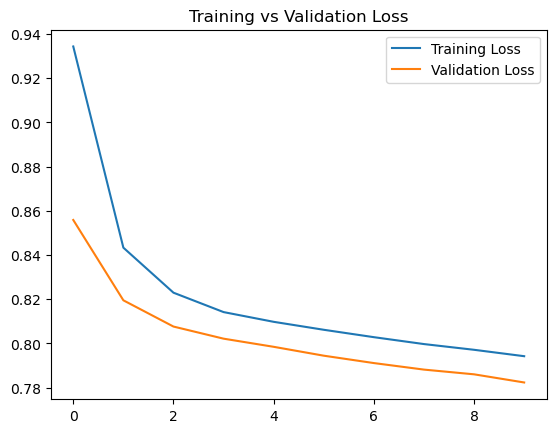

In [13]:
# Step 13: Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()